In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB,CategoricalNB
from sklearn.neighbors import KNeighborsClassifier,NeighborhoodComponentsAnalysis
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
import xgboost
import graphviz 

# Loading data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
meta = pd.read_csv("gender_submission.csv")

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Preprocessing
check the column with nan

In [4]:
print(train.columns[train.isna().any()].tolist())
print(test.columns[test.isna().any()].tolist())

['Age', 'Cabin', 'Embarked']
['Age', 'Fare', 'Cabin']


In [5]:
#train = train[["Survived","Pclass","Sex","SibSp","Parch","Fare","Age","Embarked","Name"]]
#test = test[["Pclass","Sex","SibSp","Parch","Fare","Age","Embarked","Name"]]

In [6]:
X = train[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
y = train["Survived"]
X_train,X_val,y_train,y_val = train_test_split(X,y)

In [7]:
X_val.tail

<bound method NDFrame.tail of      PassengerId  Pclass                            Name     Sex    Age  \
189          190       3             Turcin, Mr. Stjepan    male  36.00   
666          667       2     Butler, Mr. Reginald Fenton    male  25.00   
524          525       3               Kassem, Mr. Fared    male    NaN   
305          306       1  Allison, Master. Hudson Trevor    male   0.92   
812          813       2       Slemen, Mr. Richard James    male  35.00   
..           ...     ...                             ...     ...    ...   
61            62       1             Icard, Miss. Amelie  female  38.00   
671          672       1          Davidson, Mr. Thornton    male  31.00   
249          250       2   Carter, Rev. Ernest Courtenay    male  54.00   
286          287       3         de Mulder, Mr. Theodore    male  30.00   
592          593       3      Elsbury, Mr. William James    male  47.00   

     SibSp  Parch      Ticket      Fare    Cabin Embarked  
189      

In [8]:
X_train.loc[:,"nMemb"] = X_train.apply(lambda row: row.SibSp + row.Parch, axis=1)
X_train.loc[:,"Family"] = np.where(X_train["nMemb"] == 0, "None", np.where(X_train["nMemb"] > 4, "Big", "Small"))
X_train.loc[:,"Title"] = X_train.Name.str.split(".").str[0].str.split(",").str[1].str.strip()
X_val.loc[:,"nMemb"] = X_val.apply(lambda row: row.SibSp + row.Parch, axis=1)
X_val.loc[:,"Family"] = np.where(X_val["nMemb"] == 0, "None", np.where(X_val["nMemb"] > 4, "Big", "Small"))
X_val.loc[:,"Title"] = X_val.Name.str.split(".").str[0].str.split(",").str[1].str.strip()
X.loc[:,"nMemb"] = X.apply(lambda row: row.SibSp + row.Parch, axis=1)
X.loc[:,"Family"] = np.where(X["nMemb"] == 0, "None", np.where(X["nMemb"] > 4, "Big", "Small"))
X.loc[:,"Title"] = X.Name.str.split(".").str[0].str.split(",").str[1].str.strip()
test["nMemb"] = test.SibSp + test.Parch
test["Family"] = np.where(test["nMemb"] == 0, "None", np.where(test["nMemb"] > 4, "Big", "Small"))
test["Title"] = test.Name.str.split(".").str[0].str.split(",").str[1].str.strip()
X_train.loc[:,"logFare"] = np.log(X_train.Fare+0.000001) 
X_val.loc[:,"logFare"] = np.log(X_val.Fare+0.000001) 
X.loc[:,"logFare"] = np.log(X.Fare+0.000001) 
test["logFare"] = np.log(test.Fare+0.000001)

/Users/chaaya/miniconda/envs/MLbase/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/chaaya/miniconda/envs/MLbase/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train.loc[:,"Age"] = imp_mean.fit_transform(X_train["Age"].to_numpy().reshape(-1,1))[:,0]
X_val.loc[:,"Age"] = imp_mean.fit_transform(X_val["Age"].to_numpy().reshape(-1,1))[:,0]
X.loc[:,"Age"] = imp_mean.fit_transform(X["Age"].to_numpy().reshape(-1,1))[:,0]
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train.loc[:,"Embarked"] = imp_mean.fit_transform(X_train["Embarked"].to_numpy().reshape(-1,1))[:,0]
X_val.loc[:,"Embarked"] = imp_mean.fit_transform(X_val["Embarked"].to_numpy().reshape(-1,1))[:,0]
X.loc[:,"Embarked"] = imp_mean.fit_transform(X["Embarked"].to_numpy().reshape(-1,1))[:,0]
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
test.loc[:,"Age"] = imp_mean.fit_transform(test["Age"].to_numpy().reshape(-1,1))[:,0]
test.loc[:,"Fare"] = imp_mean.fit_transform(test["Fare"].to_numpy().reshape(-1,1))[:,0]

/Users/chaaya/miniconda/envs/MLbase/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/chaaya/miniconda/envs/MLbase/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/chaaya/miniconda/envs/MLbase/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [10]:
le = LabelEncoder()
X_train.loc[:,'TitleOHE'] = le.fit_transform(X_train.Title.values)
X_train.loc[:,'SexOHE'] = le.fit_transform(X_train.Sex.values)
X_train.loc[:,'EmbarkedOHE'] = le.fit_transform(X_train.Embarked.values)
X_train.loc[:,'FamilyOHE'] = le.fit_transform(X_train.Family.values)
X_val.loc[:,'TitleOHE'] = le.fit_transform(X_val.Title.values)
X_val.loc[:,'SexOHE'] = le.fit_transform(X_val.Sex.values)
X_val.loc[:,'EmbarkedOHE'] = le.fit_transform(X_val.Embarked.values)
X_val.loc[:,'FamilyOHE'] = le.fit_transform(X_val.Family.values)
X.loc[:,'TitleOHE'] = le.fit_transform(X.Title.values)
X.loc[:,'SexOHE'] = le.fit_transform(X.Sex.values)
X.loc[:,'EmbarkedOHE'] = le.fit_transform(X.Embarked.values)
X.loc[:,'FamilyOHE'] = le.fit_transform(X.Family.values)
test.loc[:,'TitleOHE'] = le.fit_transform(test.Title.values)
test.loc[:,'SexOHE'] = le.fit_transform(test.Sex.values)
test.loc[:,'EmbarkedOHE'] = le.fit_transform(test.Embarked.values)
test.loc[:,'FamilyOHE'] = le.fit_transform(test.Family.values)

/Users/chaaya/miniconda/envs/MLbase/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/chaaya/miniconda/envs/MLbase/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
X_train = X_train[["Fare","Age","Pclass","TitleOHE","SibSp","SexOHE","EmbarkedOHE","FamilyOHE"]]
X_val = X_val[["Fare","Age","Pclass","TitleOHE","SibSp","SexOHE","EmbarkedOHE","FamilyOHE"]]
X = X[["Fare","Age","Pclass","TitleOHE","SibSp","SexOHE","EmbarkedOHE","FamilyOHE"]]

In [12]:
results = {}

# Logistic Regression

The following code simply build a logistic regression with an l2 regularization

In [13]:
lrm = LogisticRegression(random_state=0,penalty="l2",max_iter=10000)
lrm_scores = cross_val_score(lrm, X, y, cv=5)
print("Logistic Regression accuracy: %0.2f (+/- %0.2f)" % (lrm_scores.mean(), lrm_scores.std() * 2))
results["lrm"] = lrm_scores

Logistic Regression accuracy: 0.80 (+/- 0.02)


# Naive Bayes

Gaussian Naive Bayes method applciation assuming the stretched hypothesis that the feature are independent, which is not true. Consider for instance, the class and the fare.

In [14]:
nb_gaussian = GaussianNB()
nb_gaussian_scores = cross_val_score(nb_gaussian, X, y, cv=5)
print("Logistic Regression accuracy: %0.2f (+/- %0.2f)" % (nb_gaussian_scores.mean(), nb_gaussian_scores.std() * 2))
results["nbg"] = nb_gaussian_scores

Logistic Regression accuracy: 0.79 (+/- 0.03)


# Nearest Neighbors

Applying the KNN algorithm. Best results were obtained using k=8

In [15]:
knn_scores={}
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_score = cross_val_score(knn, X, y, cv=5)
    print("K-NN",k,": %0.2f (+/- %0.2f)" % (knn_score.mean(), knn_score.std() * 2))
    knn_scores[k] = knn_score

K-NN 1 : 0.69 (+/- 0.06)
K-NN 2 : 0.68 (+/- 0.04)
K-NN 3 : 0.71 (+/- 0.04)
K-NN 4 : 0.70 (+/- 0.03)
K-NN 5 : 0.70 (+/- 0.06)
K-NN 6 : 0.69 (+/- 0.06)
K-NN 7 : 0.71 (+/- 0.08)
K-NN 8 : 0.71 (+/- 0.05)
K-NN 9 : 0.71 (+/- 0.07)
K-NN 10 : 0.71 (+/- 0.06)
K-NN 11 : 0.71 (+/- 0.06)
K-NN 12 : 0.71 (+/- 0.08)
K-NN 13 : 0.71 (+/- 0.09)
K-NN 14 : 0.70 (+/- 0.08)
K-NN 15 : 0.71 (+/- 0.08)
K-NN 16 : 0.71 (+/- 0.11)
K-NN 17 : 0.71 (+/- 0.11)
K-NN 18 : 0.70 (+/- 0.13)
K-NN 19 : 0.71 (+/- 0.11)


In [16]:
def highestScore(scores):
    mean = 0
    std = 1000
    k_max = 0
    max = None
    for k,val in scores.items():
        if (val.mean() > mean):
            k_max = k
            mean = val.mean()
            std = val.std()
            max = val
    return k_max,max
results["KNN"]=highestScore(knn_scores)[1]

Linear transform data to maximize the LOO results.

In [17]:
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn_scores={}
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
    knn_score = cross_val_score(nca_pipe, X, y, cv=5)
    print("K-NN nca",k,": %0.2f (+/- %0.2f)" % (knn_score.mean(), knn_score.std() * 2))
    knn_scores[k] = knn_score
results["KNNnca"]=highestScore(knn_scores)[1]

K-NN nca 1 : 0.70 (+/- 0.10)
K-NN nca 2 : 0.70 (+/- 0.07)
K-NN nca 3 : 0.72 (+/- 0.06)
K-NN nca 4 : 0.72 (+/- 0.06)
K-NN nca 5 : 0.71 (+/- 0.08)
K-NN nca 6 : 0.72 (+/- 0.07)
K-NN nca 7 : 0.73 (+/- 0.09)
K-NN nca 8 : 0.72 (+/- 0.10)
K-NN nca 9 : 0.72 (+/- 0.09)
K-NN nca 10 : 0.71 (+/- 0.10)
K-NN nca 11 : 0.71 (+/- 0.11)
K-NN nca 12 : 0.71 (+/- 0.10)
K-NN nca 13 : 0.71 (+/- 0.10)
K-NN nca 14 : 0.70 (+/- 0.10)
K-NN nca 15 : 0.71 (+/- 0.10)
K-NN nca 16 : 0.69 (+/- 0.10)
K-NN nca 17 : 0.70 (+/- 0.11)
K-NN nca 18 : 0.69 (+/- 0.13)
K-NN nca 19 : 0.70 (+/- 0.12)


In [18]:
results

{'lrm': array([0.79329609, 0.80337079, 0.79213483, 0.80337079, 0.81460674]),
 'nbg': array([0.77094972, 0.78651685, 0.79213483, 0.81460674, 0.80898876]),
 'KNN': array([0.65921788, 0.69101124, 0.70786517, 0.76404494, 0.75280899]),
 'KNNnca': array([0.65363128, 0.71348315, 0.7247191 , 0.75842697, 0.78089888])}

## Decision Tree

Testing decision trees using two difference criterion for the selection of the best split: GINI index and entropy. No major differences were observed between them.

In [19]:
DT = DecisionTreeClassifier(criterion="entropy",random_state=0).fit(X_train,y_train)
DT_scores = cross_val_score(DT, X, y, cv=5)
print("Decistion Tree entropy index accuracy: %0.2f (+/- %0.2f)" % (DT_scores.mean(), DT_scores.std() * 2))
DT = DecisionTreeClassifier(criterion="gini",random_state=0).fit(X_train,y_train)
DT_scores = cross_val_score(DT, X, y, cv=5)
print("Decistion Tree GINI index accuracy: %0.2f (+/- %0.2f)" % (DT_scores.mean(), DT_scores.std() * 2))

Decistion Tree entropy index accuracy: 0.78 (+/- 0.03)
Decistion Tree GINI index accuracy: 0.77 (+/- 0.05)


Since decision tree are highly affected by pruning. Let's see if we can improve classification considering less leaves and deciding the depth of the tree. In order to decide the number of leaves too prune, I used the cost complexity pruning criteria which is implemented in scikit learn. This method is based on the complexity parameter alpha: for each alpha the algorithm find the subtree which minimize the cost complexity measure (for more info: https://scikit-learn.org/stable/modules/tree.html)

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

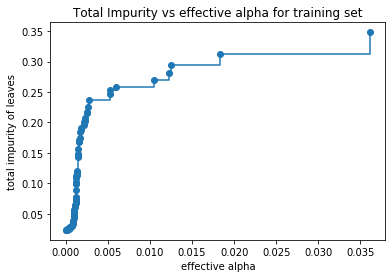

In [20]:
path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [21]:
DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, criterion="entropy").fit(X_train, y_train)
    DTs.append(DT)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      DTs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.1304370657471003


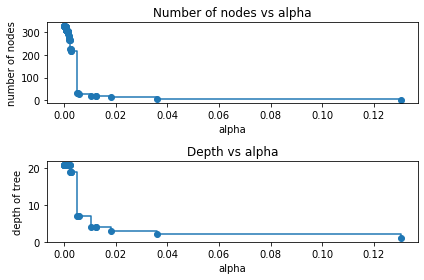

In [22]:
ccp_alphas = ccp_alphas

node_counts = [DT.tree_.node_count for DT in DTs]
depth = [DT.tree_.max_depth for DT in DTs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

No handles with labels found to put in legend.


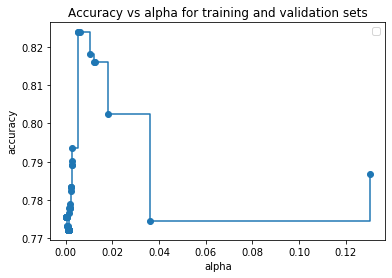

In [23]:
DT_scores = {DT.ccp_alpha:cross_val_score(DT,X, y,cv=5) for DT in DTs}

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(list(DT_scores.keys()), [array.mean() for array in DT_scores.values()], marker='o',
        drawstyle="steps-post")
ax.legend()
plt.show()

Best results were obtained having an alpha score of 0.003

In [24]:
DT = DecisionTreeClassifier(random_state=0, ccp_alpha=highestScore(DT_scores)[0], criterion="entropy")
DT_scores = cross_val_score(DT,X, y,cv=5)
print("Decistion Tree entropy accuracy: %0.2f (+/- %0.2f)" % (DT_scores.mean(), DT_scores.std() * 2))
results["DT"]=DT_scores

Decistion Tree entropy index accuracy: 0.82 (+/- 0.04)


## Random Forest

Using Random Forest as next step after Decision Trees

In [25]:
RF = RandomForestClassifier(n_estimators=10000,random_state=0)
RF_scores = cross_val_score(RF,X, y,cv=5)
print("Decistion Tree entropy accuracy: %0.2f (+/- %0.2f)" % (RF_scores.mean(), RF_scores.std() * 2))
results["RF"]=RF_scores

Decistion Tree entropy index accuracy: 0.80 (+/- 0.06)


Feature extraction using Gini Importance

No handles with labels found to put in legend.


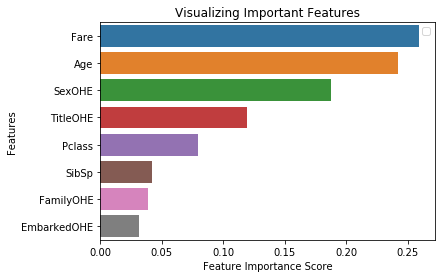

In [26]:
RF = RandomForestClassifier(n_estimators=10000,random_state=0).fit(X,y)
feature_imp = pd.Series(RF.feature_importances_,index=X_train.columns).sort_values(ascending=False)
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Feature importance using the more robust mean decrease accuracy method which is permutation based

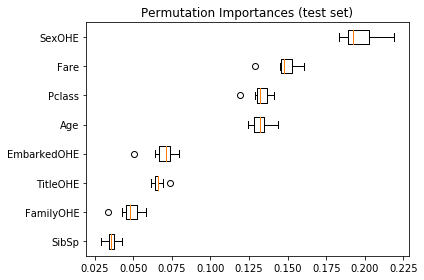

In [27]:
result = permutation_importance(RF, X, y, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_val.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [31]:
# removing low importance features
X_red = X[["Fare","Age","Pclass","SexOHE"]]

In [32]:
RF = RandomForestClassifier(n_estimators=10000,random_state=0)
RF_scores = cross_val_score(RF,X_red, y,cv=5)
print("Random Forest entropy accuracy: %0.2f (+/- %0.2f)" % (RF_scores.mean(), RF_scores.std() * 2))

Random Forest entropy accuracy: 0.82 (+/- 0.05)


In [33]:
ER = ExtraTreesClassifier(n_estimators=100000,random_state=0).fit(X,y)
ER_scores = cross_val_score(ER,X, y,cv=5)
print("Extra Trees entropy accuracy: %0.2f (+/- %0.2f)" % (ER_scores.mean(), ER_scores.std() * 2))
results["ET"]=ER_scores

Extra Trees entropy accuracy: 0.80 (+/- 0.07)


## Support Vector Machine

In [34]:
SVM = svm.SVC(kernel="linear")
SVM_scores = cross_val_score(SVM,X, y,cv=5)
print("SVM with linear kernel accuracy: %0.2f (+/- %0.2f)" % (SVM_scores.mean(), SVM_scores.std() * 2))
results["SVMlinear"]=SVM_scores

SVM with linear kernel accuracy: 0.79 (+/- 0.03)


In [35]:
SVM = svm.SVC(kernel="rbf")
SVM_scores = cross_val_score(SVM,X, y,cv=5)
print("SVM with rbf kernel accuracy: %0.2f (+/- %0.2f)" % (SVM_scores.mean(), SVM_scores.std() * 2))
results["SVMrbf"]=SVM_scores

SVM with rbf kernel accuracy: 0.67 (+/- 0.09)


## AdaBoost

In [36]:
AB = AdaBoostClassifier(n_estimators=1000, random_state=0)
AB_scores = cross_val_score(AB,X, y,cv=5)
print("Ada Boost accuracy: %0.2f (+/- %0.2f)" % (AB_scores.mean(), AB_scores.std() * 2))
results["AB"]=AB_scores

Ada Boost accuracy: 0.82 (+/- 0.05)


## XGboost with grid search

In [39]:
num_round = 1000
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_val, label=y_val)

In [40]:
XGB = XGBClassifier(n_estimators=1000,random_state=0)
XGB_scores = cross_val_score(XGB,X, y,cv=5)
print("XGBoost accuracy: %0.2f (+/- %0.2f)" % (XGB_scores.mean(), XGB_scores.std() * 2))
results["XGB"]=XGB_scores

XGBoost accuracy: 0.82 (+/- 0.05)


Tuning parameters

In [41]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [43]:
XGB = xgboost.XGBClassifier(booster="gbtree")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(XGB, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model with rank: 1
Mean validation score: 0.820 (std: 0.010)
Parameters: {'colsample_bytree': 0.8709669054613949, 'gamma': 0.38122934287034527, 'learning_rate': 0.29302969102852483, 'max_depth': 2, 'n_estimators': 137, 'subsample': 0.8145925405938379}



[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   26.3s finished


In [44]:
cv_results = search.cv_results_
idx = np.flatnonzero(search.cv_results_['rank_test_score'] == 1)
params = cv_results['params'][int(idx)]

In [45]:
XGB = XGBClassifier(booster="gbtree",
                    colsample_bytree = params["colsample_bytree"],
                    n_estimators=params["n_estimators"],max_depth=params["max_depth"],
                    subsample=params["subsample"],gamma=params["gamma"],
                    learning_rate=params["learning_rate"],random_state=0)
XGB_scores = cross_val_score(XGB,X, y,cv=5)
print("XGBoost accuracy: %0.2f (+/- %0.2f)" % (XGB_scores.mean(), XGB_scores.std() * 2))
results["XGB"]=XGB_scores

XGBoost accuracy: 0.83 (+/- 0.05)


## Voting Classifier

In [48]:
for i,j in results.items():
    print(i,j.mean(),j.std())

lrm 0.8013558470905782 0.008169369496848525
nbg 0.7946393823363254 0.015735618849680742
KNN 0.7149896428347248 0.03891770153927944
KNNnca 0.7262318749607684 0.043498664808431356
DT 0.8237963718536188 0.018634593851450033
RF 0.8047203565375682 0.03039421138886655
ET 0.7968614650681062 0.03280662748817314
SVMlinear 0.7912309334002888 0.015009764319191763
SVMrbf 0.6723808925993346 0.046695487661212016
AB 0.817079907099366 0.026573064680987322
XGB 0.8339150084740444 0.024094975627904865


In [59]:
vc = VotingClassifier(estimators=[('lrm', lrm),("RF",RF),("DT",DT),("AB",AB),("XGB",XGB)],voting='soft')
vc_scores = cross_val_score(vc,X, y,cv=5)
print("Voting accuracy: %0.2f (+/- %0.2f)" % (vc_scores.mean(), vc_scores.std() * 2))
results["VC"]=vc_scores

Voting accuracy: 0.83 (+/- 0.03)


In [66]:
vc = VotingClassifier(estimators=[('lrm', lrm),("RF",RF),("DT",DT),("AB",AB),("XGB",XGB)],voting='hard').fit(X,y)
X_test = test[["Fare","Age","Pclass","TitleOHE","SibSp","SexOHE","EmbarkedOHE","FamilyOHE"]]
y_pred = vc.predict(X_test)

In [67]:
predictions_df = pd.DataFrame(test["PassengerId"])
predictions_df["Survived"] = y_pred
predictions_df.to_csv('./titanic_prediction.csv', index=False)

In [68]:
results

{'lrm': array([0.79329609, 0.80337079, 0.79213483, 0.80337079, 0.81460674]),
 'nbg': array([0.77094972, 0.78651685, 0.79213483, 0.81460674, 0.80898876]),
 'KNN': array([0.65921788, 0.69101124, 0.70786517, 0.76404494, 0.75280899]),
 'KNNnca': array([0.65363128, 0.71348315, 0.7247191 , 0.75842697, 0.78089888]),
 'DT': array([0.82122905, 0.81460674, 0.83146067, 0.79775281, 0.85393258]),
 'RF': array([0.79888268, 0.80337079, 0.84269663, 0.75280899, 0.8258427 ]),
 'ET': array([0.79329609, 0.76404494, 0.83707865, 0.75842697, 0.83146067]),
 'SVMlinear': array([0.80446927, 0.79775281, 0.78651685, 0.76404494, 0.80337079]),
 'SVMrbf': array([0.58100559, 0.71348315, 0.69101124, 0.68539326, 0.69101124]),
 'AB': array([0.79888268, 0.78089888, 0.85955056, 0.82022472, 0.8258427 ]),
 'XGB': array([0.81564246, 0.82022472, 0.87078652, 0.80898876, 0.85393258]),
 'VC': array([0.83240223, 0.8258427 , 0.84831461, 0.80898876, 0.84269663])}